开始训练...
Iter    0, Loss: 0.8511
Iter  300, Loss: 0.0125
Iter  600, Loss: 0.0126
Iter  900, Loss: 0.0054
Iter 1200, Loss: 0.0120
Iter 1500, Loss: 0.0093


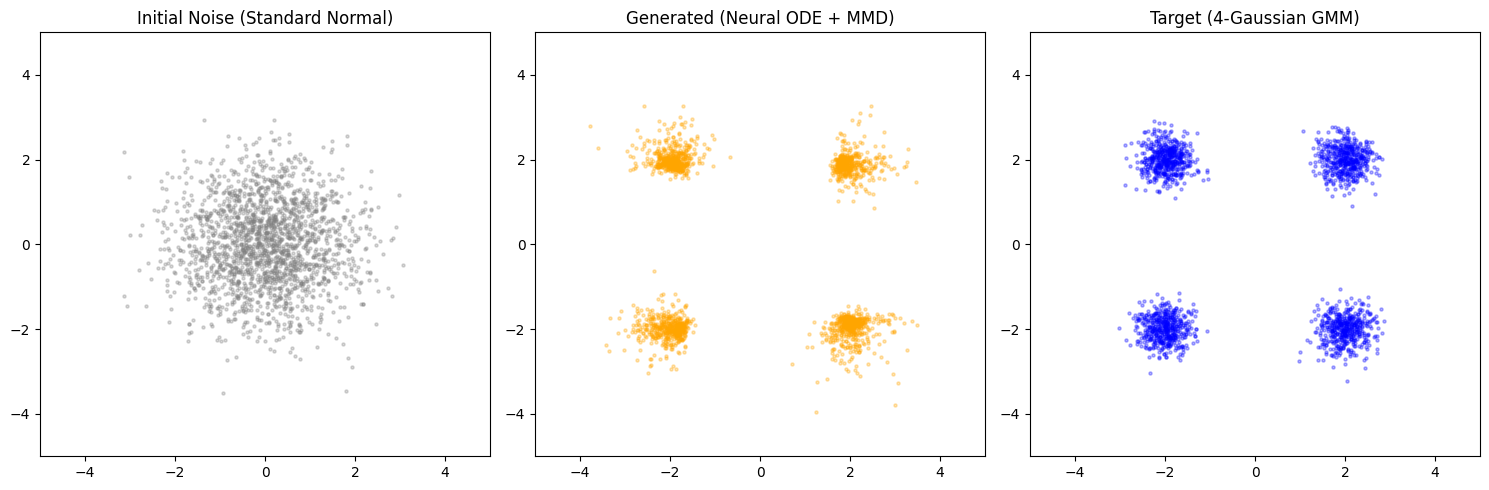

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# 1. 定义神经向量场
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),  # 增加宽度以应对 4 个中心
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
        )

    def forward(self, t, x):
        # 广播时间 t
        t_vec = torch.ones(x.shape[0], 1).to(x.device) * t
        tx = torch.cat([x, t_vec], dim=1)
        return self.net(tx)

# 2. 改进的 MMD Loss (多尺度核更稳定)
def gaussian_kernel(x, y, sigma=[0.5, 1.0, 2.0]):
    dist = torch.cdist(x, y)**2
    res = 0.
    for s in sigma:
        res += torch.exp(-dist / (2 * s**2))
    return res

def complex_distribution_loss(z1, target_x):
    # 计算 MMD 
    k_zz = gaussian_kernel(z1, z1).mean()
    k_zx = gaussian_kernel(z1, target_x).mean()
    k_xx = gaussian_kernel(target_x, target_x).mean()
    return k_zz - 2 * k_zx + k_xx

# 3. 修正后的采样函数
def sample_gmm(batch_size=512):
    # 四个中心
    means = torch.tensor([[2.0, 2.0], [-2.0, -2.0], [2.0, -2.0], [-2.0, 2.0]])
    # 修复：确保能随机选到所有 4 个中心
    indices = torch.randint(0, len(means), (batch_size,)) 
    m = means[indices]
    return m + torch.randn(batch_size, 2) * 0.3 # 减小方差使簇更清晰

# 4. 训练设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=0.005) # 略微降低学习率增加稳定性
t0, t1 = 0.0, 1.0

# 5. 训练循环
print("开始训练...")
for i in range(1501): # 增加迭代次数
    optimizer.zero_grad()
    
    target_x = sample_gmm(512).to(device)
    z0 = torch.randn(512, 2).to(device)
    
    # ODE 积分
    z1 = odeint(func, z0, torch.tensor([t0, t1]).to(device), method='rk4')[-1]
    
    loss = complex_distribution_loss(z1, target_x)
    loss.backward()
    optimizer.step()
    
    if i % 300 == 0:
        print(f"Iter {i:4d}, Loss: {loss.item():.4f}")

# 6. 可视化
with torch.no_grad():
    z0_test = torch.randn(2000, 2).to(device)
    t_space = torch.linspace(t0, t1, 2).to(device)
    z1_generated = odeint(func, z0_test, t_space)[-1].cpu()
    target_real = sample_gmm(2000)

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(z0_test[:,0].cpu(), z0_test[:,1].cpu(), alpha=0.3, s=5, color='gray')
    plt.title("Initial Noise (Standard Normal)")
    plt.xlim(-5, 5); plt.ylim(-5, 5)
    
    plt.subplot(1, 3, 2)
    plt.scatter(z1_generated[:,0], z1_generated[:,1], alpha=0.3, s=5, color='orange')
    plt.title("Generated (Neural ODE + MMD)")
    plt.xlim(-5, 5); plt.ylim(-5, 5)

    plt.subplot(1, 3, 3)
    plt.scatter(target_real[:,0], target_real[:,1], alpha=0.3, s=5, color='blue')
    plt.title("Target (4-Gaussian GMM)")
    plt.xlim(-5, 5); plt.ylim(-5, 5)

    plt.tight_layout()
    plt.show()

Epoch    0 | Loss: 8.6670
Epoch  100 | Loss: 2.9762
Epoch  200 | Loss: 2.5671
Epoch  300 | Loss: 2.6365
Epoch  400 | Loss: 2.5550
Epoch  500 | Loss: 2.6334
Epoch  600 | Loss: 2.6072


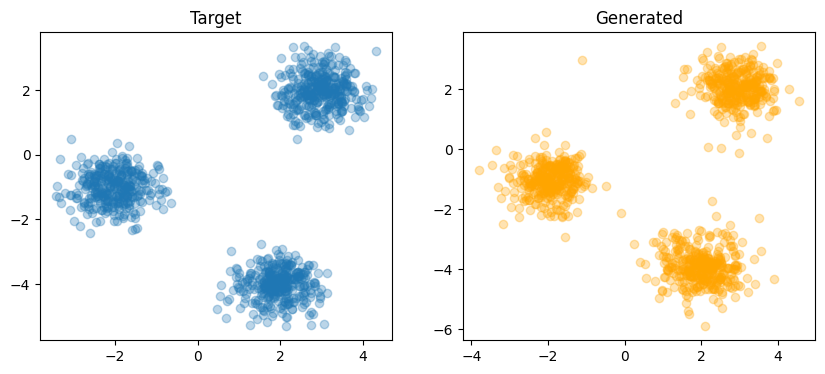

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint  # 训练用
from torchdiffeq import odeint          # 采样用

# 1. 速度场网络
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=64):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )

    def get_divergence(self, x, v):
        div = 0.
        for i in range(x.shape[1]):
            div += torch.autograd.grad(v[:, i].sum(), x, create_graph=True)[0][:, i]
        return div

    def forward(self, t, states):
        x = states[0]
        with torch.set_grad_enabled(True):
            x.requires_grad_(True)
            v = self.net(x)
            div = self.get_divergence(x, v)
        return (v, -div)

# 2. 模型封装
class NeuralODEMLE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODEMLE, self).__init__()
        self.ode_func = ode_func
        device = next(ode_func.parameters()).device  # 获取网络所在设备
        self.prior = torch.distributions.MultivariateNormal(
            torch.zeros(2, device=device),
            torch.eye(2, device=device)
        )

    def get_log_likelihood(self, x_data):
        batch_size = x_data.shape[0]
        logp_initial = torch.zeros(batch_size).to(x_data.device)
        t_span = torch.tensor([1.0, 0.0]).to(x_data.device)
        
        states_t0 = odeint_adjoint(
            self.ode_func, 
            (x_data, logp_initial), 
            t_span, 
            method='dopri5'
        )
        z_t0, delta_logp = states_t0[0][-1], states_t0[1][-1]
        return self.prior.log_prob(z_t0) - delta_logp

    def sample(self, n_samples):
        device = next(self.parameters()).device
        with torch.no_grad():
            z = self.prior.sample((n_samples,)).to(device)
            t_span = torch.tensor([0.0, 1.0]).to(device)
            
            # 修正：采样不需要算梯度，直接用基础的 odeint 绕过伴随参数检查
            # 并且直接传入 self.ode_func.net
            def v_only(t, x): 
                return self.ode_func.net(x)
                
            # 使用普通的 odeint
            traj = odeint(v_only, z, t_span, method='dopri5')
            return traj[-1]

# 3. 训练与绘图逻辑
def get_real_samples(batch_size=128):
    centers = torch.tensor([[3.0, 2.0], [-2.0, -1.0], [2.0, -4.0]])
    idx = torch.randint(0, len(centers), (batch_size,))
    return centers[idx] + torch.randn(batch_size, 2) * 0.5

def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NeuralODEMLE(ODEFunc().to(device)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-3)

    for epoch in range(601):
        real_x = get_real_samples(128).to(device)
        loss = -model.get_log_likelihood(real_x).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f}")
    return model

def visualize(model):
    model.eval()
    real_data = get_real_samples(1000)
    gen_data = model.sample(1000).cpu()
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.3); plt.title("Target")
    plt.subplot(1, 2, 2); plt.scatter(gen_data[:, 0], gen_data[:, 1], alpha=0.3, color='orange'); plt.title("Generated")
    plt.show()

if __name__ == "__main__":
    m = train()
    visualize(m)

Epoch    0 | Loss: 8.1648
Epoch  100 | Loss: 4.1389
Epoch  200 | Loss: 3.3332
Epoch  300 | Loss: 2.9040
Epoch  400 | Loss: 2.6045
Epoch  500 | Loss: 2.7493
Epoch  600 | Loss: 2.7414


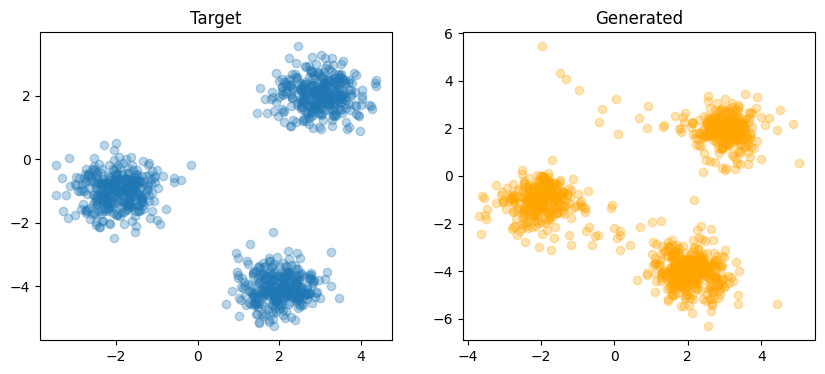

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint, odeint

# -------------------------------
# 1. 速度场网络
# -------------------------------
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=64):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        # 初始化
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.1)
                nn.init.constant_(m.bias, 0.0)

    def get_divergence(self, x, v):
        # v: (batch, dim), x: (batch, dim)
        div = 0.
        for i in range(x.shape[1]):
            div += torch.autograd.grad(v[:, i].sum(), x, create_graph=True)[0][:, i]
        return div

    def forward(self, t, states):
        x = states[0]
        with torch.set_grad_enabled(True):
            x.requires_grad_(True)
            v = self.net(x)
            div = self.get_divergence(x, v)
        return (v, -div)

# -------------------------------
# 2. Neural ODE MLE 模型
# -------------------------------
class NeuralODEMLE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODEMLE, self).__init__()
        self.ode_func = ode_func
        device = next(ode_func.parameters()).device
        self.prior = torch.distributions.MultivariateNormal(
            torch.zeros(2, device=device),
            torch.eye(2, device=device)
        )

    def get_log_likelihood(self, x_data):
        batch_size = x_data.shape[0]
        logp_initial = torch.zeros(batch_size, device=x_data.device)
        t_span = torch.tensor([1.0, 0.0], device=x_data.device)  # 逆向积分

        states_t0 = odeint_adjoint(
            self.ode_func,
            (x_data, logp_initial),
            t_span,
            method='dopri5'
        )
        z_t0, delta_logp = states_t0[0][-1], states_t0[1][-1]

        # 对数似然
        return self.prior.log_prob(z_t0) - delta_logp

    def sample(self, n_samples):
        device = next(self.parameters()).device
        with torch.no_grad():
            z = self.prior.sample((n_samples,)).to(device)
            t_span = torch.tensor([0.0, 1.0], device=device)

            # 正向积分生成 x
            def v_only(t, x):
                return self.ode_func.net(x)

            traj = odeint(v_only, z, t_span, method='dopri5')
            return traj[-1]

# -------------------------------
# 3. 数据与训练
# -------------------------------
def get_real_samples(batch_size=128):
    centers = torch.tensor([[3.0, 2.0], [-2.0, -1.0], [2.0, -4.0]])
    idx = torch.randint(0, len(centers), (batch_size,))
    return centers[idx] + torch.randn(batch_size, 2) * 0.5

def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ode_func = ODEFunc().to(device)
    model = NeuralODEMLE(ode_func).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(601):
        real_x = get_real_samples(128).to(device)
        logp = model.get_log_likelihood(real_x)
        loss = -logp.mean()  # 对数似然损失

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f}")
    return model

# -------------------------------
# 4. 可视化
# -------------------------------
def visualize(model):
    model.eval()
    real_data = get_real_samples(1000)
    gen_data = model.sample(1000).cpu()
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.3)
    plt.title("Target")
    plt.subplot(1, 2, 2)
    plt.scatter(gen_data[:, 0], gen_data[:, 1], alpha=0.3, color='orange')
    plt.title("Generated")
    plt.show()

# -------------------------------
# 5. 主函数
# -------------------------------
if __name__ == "__main__":
    model = train()
    visualize(model)


[t-FM] Epoch    0 | Loss: 14.9249
[t-FM] Epoch  200 | Loss: 9.1986
[t-FM] Epoch  400 | Loss: 8.2834
[t-FM] Epoch  600 | Loss: 7.4908
[t-FM] Epoch  800 | Loss: 6.5565
[t-FM] Epoch 1000 | Loss: 7.0819
[t-FM] Epoch 1200 | Loss: 6.6595
[t-FM] Epoch 1400 | Loss: 5.8856
[t-FM] Epoch 1600 | Loss: 6.8030
[t-FM] Epoch 1800 | Loss: 6.8736
[t-FM] Epoch 2000 | Loss: 6.3884
[t-FM] Epoch 2200 | Loss: 5.1799
[t-FM] Epoch 2400 | Loss: 6.4584
[t-FM] Epoch 2600 | Loss: 5.0823
[t-FM] Epoch 2800 | Loss: 4.9869
[t-FM] Epoch 3000 | Loss: 4.6318
[t-FM] Epoch 3200 | Loss: 6.1309
[t-FM] Epoch 3400 | Loss: 7.1227
[t-FM] Epoch 3600 | Loss: 5.6840
[t-FM] Epoch 3800 | Loss: 7.2131
[t-FM] Epoch 4000 | Loss: 5.6360
[t-FM] Epoch 4200 | Loss: 4.5558
[t-FM] Epoch 4400 | Loss: 6.4361
[t-FM] Epoch 4600 | Loss: 6.4241
[t-FM] Epoch 4800 | Loss: 5.9111
[t-FM] Epoch 5000 | Loss: 6.5214
[t-FM] Epoch 5200 | Loss: 6.3237
[t-FM] Epoch 5400 | Loss: 5.7954
[t-FM] Epoch 5600 | Loss: 6.5795
[t-FM] Epoch 5800 | Loss: 6.8252
[t-FM] Ep

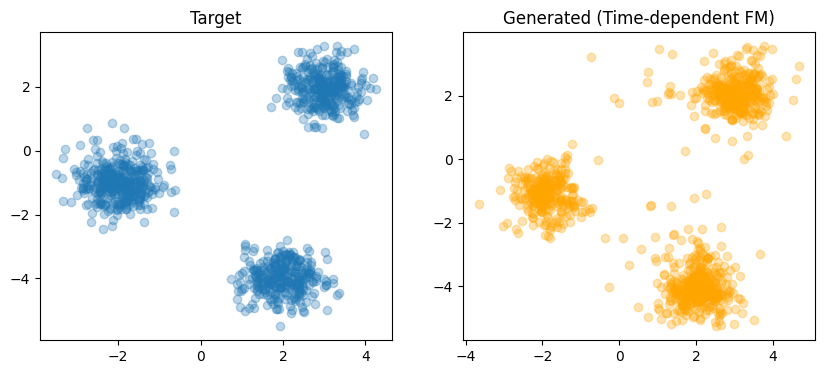

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# -------------------------------
# 1. Time-dependent 速度场网络
# -------------------------------
class ODEFuncTD(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # 输入维度增加 1: t
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),  # x:2 + t:1
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        # 初始化
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.1)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x, t):
        # x: (batch,2), t: (batch,1)
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

    def sample_from_fm(self, n_samples):
        device = next(self.parameters()).device
        z = torch.randn(n_samples, 2, device=device)
        t_span = torch.tensor([0.0, 1.0], device=device)

        with torch.no_grad():
            traj = odeint(
                lambda t, x: self.forward(x, t * torch.ones(x.shape[0],1,device=x.device)),
                z,
                t_span,
                method='dopri5'
            )
        return traj[-1]

# -------------------------------
# 2. Flow Matching Loss (time-dependent)
# -------------------------------
def flow_matching_loss_td(ode_func, x_data):
    device = x_data.device
    batch_size = x_data.shape[0]

    # sample z ~ N(0, I)
    z = torch.randn_like(x_data)

    # sample t ~ Uniform(0,1)
    t = torch.rand(batch_size, 1, device=device)

    # interpolate
    x_t = (1 - t) * z + t * x_data

    # target velocity
    v_target = x_data - z

    # predicted velocity
    v_pred = ode_func(x_t, t)

    # MSE loss
    loss = ((v_pred - v_target) ** 2).sum(dim=1).mean()
    return loss

# -------------------------------
# 3. 数据生成
# -------------------------------
def get_real_samples(batch_size=128):
    centers = torch.tensor([[3.0, 2.0], [-2.0, -1.0], [2.0, -4.0]])
    idx = torch.randint(0, len(centers), (batch_size,))
    return centers[idx] + torch.randn(batch_size, 2) * 0.5

# -------------------------------
# 4. 训练函数
# -------------------------------
def train_flow_matching_td(epochs=10001, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ode_func = ODEFuncTD().to(device)
    optimizer = optim.Adam(ode_func.parameters(), lr=lr)

    for epoch in range(epochs):
        real_x = get_real_samples(128).to(device)
        loss = flow_matching_loss_td(ode_func, real_x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"[t-FM] Epoch {epoch:4d} | Loss: {loss.item():.4f}")

    return ode_func

# -------------------------------
# 5. 可视化
# -------------------------------
def visualize(ode_func):
    ode_func.eval()
    real_data = get_real_samples(1000)
    gen_data = ode_func.sample_from_fm(1000).cpu()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(real_data[:,0], real_data[:,1], alpha=0.3)
    plt.title("Target")

    plt.subplot(1, 2, 2)
    plt.scatter(gen_data[:,0], gen_data[:,1], alpha=0.3, color='orange')
    plt.title("Generated (Time-dependent FM)")
    plt.show()

# -------------------------------
# 6. 主函数
# -------------------------------
if __name__ == "__main__":
    model = train_flow_matching_td()
    visualize(model)


[Step 0] Loss: 1.4297
[Step 1000] Loss: 1.0040
[Step 2000] Loss: 0.9781
[Step 3000] Loss: 0.9528
[Step 4000] Loss: 0.9391
[Step 5000] Loss: 1.0382
[Step 6000] Loss: 1.0435
[Step 7000] Loss: 0.9522
[Step 8000] Loss: 0.8494
[Step 9000] Loss: 1.0708


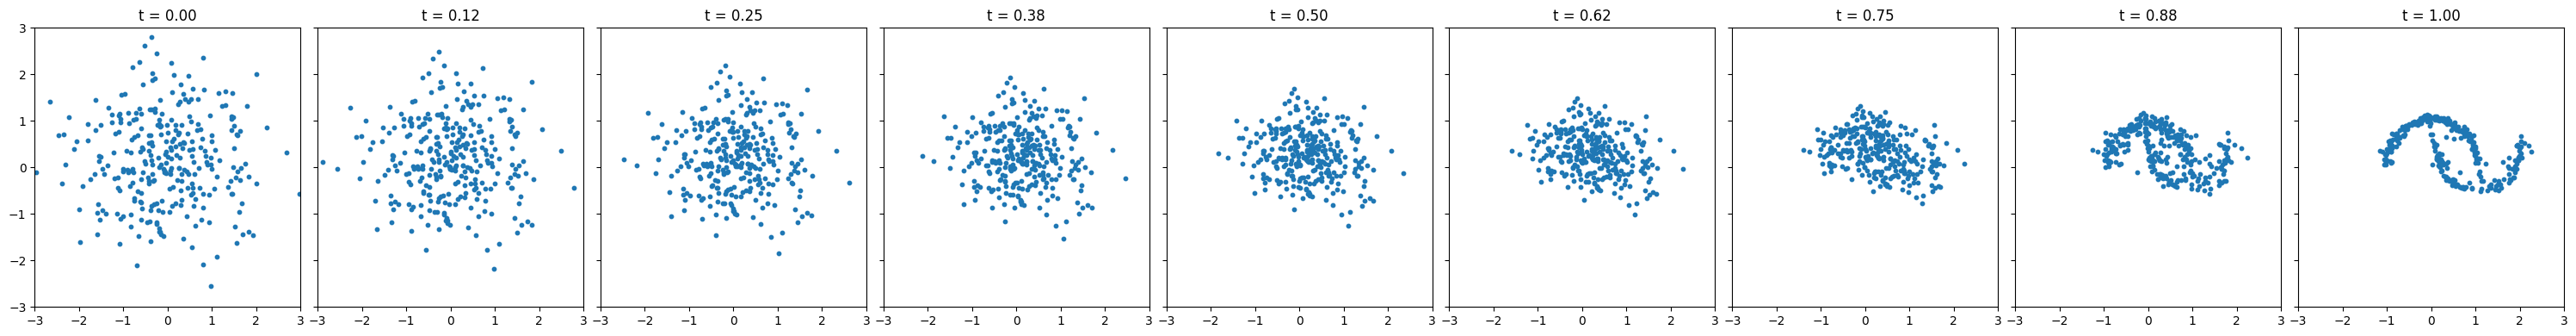

In [9]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# -------------------------------
# 1. Flow 网络
# -------------------------------
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        # x_t: (batch, 2), t: (batch,1)
        xt = torch.cat([x_t, t], dim=-1)
        return self.net(xt)

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        # broadcast t
        t_start = t_start.view(-1, 1).expand(x_t.shape[0], 1)
        t_end = t_end.view(-1, 1).expand(x_t.shape[0], 1)
        dt = t_end - t_start

        # midpoint method
        k1 = self.forward(x_t, t_start)
        x_mid = x_t + k1 * dt / 2
        t_mid = t_start + dt / 2
        k2 = self.forward(x_mid, t_mid)
        x_next = x_t + k2 * dt
        return x_next

# -------------------------------
# 2. 训练
# -------------------------------
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

for step in range(10000):
    x_1 = torch.tensor(make_moons(256, noise=0.05)[0], dtype=torch.float32)
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(x_t, t), dx_t).backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f"[Step {step}] Loss: {loss_fn(flow(x_t, t), dx_t).item():.4f}")

# -------------------------------
# 3. 采样 & 可视化
# -------------------------------
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x[:, 0], x[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    t0 = time_steps[i].expand(x.shape[0])
    t1 = time_steps[i + 1].expand(x.shape[0])
    x = flow.step(x, t0, t1)
    axes[i + 1].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 数据准备
batch_size = 256
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # <-- 注释掉或移除这行，让图像保持 (C, H, W) 形状
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# --- 时间嵌入层 (用于 CNN) ---
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        # x 预期是 (batch,) 或 (batch, 1)
        if x.dim() == 2:
            x = x.squeeze(-1) # 变成 (batch,)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1) # (batch, embed_dim)

# 2. 升级版 Flow 网络 (CNN 版本)
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.mlp = nn.Linear(time_embed_dim, out_ch) # 将时间注入卷积
        self.act = nn.GELU()

    def forward(self, x, t_emb):
        h = self.conv(x)
        # 核心：把时间信号“加”到图像特征里
        # t_emb: (batch, time_embed_dim) -> (batch, time_embed_dim, 1, 1) -> (batch, out_ch, H, W)
        h = h + self.mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        return self.act(h)

class SimpleCNNFlow(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embed_dim = 64
        self.time_mlp = nn.Sequential(
            nn.Linear(1, self.time_embed_dim), nn.GELU(), nn.Linear(self.time_embed_dim, self.time_embed_dim)
            # 或者使用 GaussianFourierProjection(self.time_embed_dim)
        )
        
        # 简单的卷积层结构
        self.inc = nn.Conv2d(1, 32, 3, padding=1) # MNIST 1通道
        self.blk1 = ConvBlock(32, 64, self.time_embed_dim)
        self.blk2 = ConvBlock(64, 32, self.time_embed_dim)
        self.outc = nn.Conv2d(32, 1, 3, padding=1) # 输出 1通道

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        # x: (B, 1, 28, 28)
        # t: (B,) 或 (B, 1)
        
        # 确保 t 是 (B, 1) 用于 time_mlp
        if t.dim() == 1:
            t = t.unsqueeze(-1) # (B,) -> (B, 1)
        
        t_emb = self.time_mlp(t) # (B, time_embed_dim)
        
        h = self.inc(x) # (B, 32, 28, 28)
        h = self.blk1(h, t_emb) # (B, 64, 28, 28)
        h = self.blk2(h, t_emb) # (B, 32, 28, 28)
        out = self.outc(h) # (B, 1, 28, 28)
        
        return out # 返回图像形状，而不是展平

    @torch.no_grad()
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        # x_t: (B, 1, 28, 28)
        # t_start, t_end: (B,)
        
        dt = (t_end - t_start).view(-1, 1, 1, 1) # 适配 (B, C, H, W)
        
        # RK2 Midpoint
        k1 = self.forward(x_t, t_start) # t_start 仍为 (B,)，forward 内部处理
        x_mid = x_t + k1 * dt / 2
        
        t_mid = t_start + (t_end - t_start) / 2 # (B,)
        
        k2 = self.forward(x_mid, t_mid)
        x_next = x_t + k2 * dt
        
        return x_next

# 3. 训练配置
#flow = Flow(dim=784, h=1024).to(device) # <-- 这是旧的 MLP 模型，不要用！
flow = SimpleCNNFlow().to(device) # <-- 正确的，使用 CNN 模型！
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 20 # 50 Epochs 应该能看到不错的数字了
print(f"Starting training on {device} for {epochs} epochs...")

for epoch in range(epochs):
    flow.train()
    total_loss = 0
    for batch_idx, (x_1, _) in enumerate(train_loader):
        x_1 = x_1.to(device) # (B, 1, 28, 28)
        x_0 = torch.randn_like(x_1) # (B, 1, 28, 28)
        
        t = torch.rand(x_1.shape[0]).to(device) # (B,)
        
        # 插值: x_t 也是 (B, 1, 28, 28)
        t_view_for_interpolation = t.view(-1, 1, 1, 1)
        x_t = (1 - t_view_for_interpolation) * x_0 + t_view_for_interpolation * x_1
        target = x_1 - x_0 # (B, 1, 28, 28)
        
        optimizer.zero_grad()
        # pred 也是 (B, 1, 28, 28)
        pred = flow

Starting training on cuda for 50 epochs...
